In [ ]:
#크롤링시 필요한 라이브러리 불러오기
from bs4 import BeautifulSoup
import requests
import re
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta

# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)

def makeUrl(search, start_pg, end_pg, start_date, end_date):
    if start_pg == end_pg:
        start_page = makePgNum(start_pg)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&sort=0&photo=0&field=0&pd=3&ds="+start_date+"&de="+end_date+"&mynews=0&office_type=0&office_section_code=0&news_office_checked=&office_category=0&service_area=0&nso=so:r,p:from20231122to20231122,a:all"+"&start=" + str(start_page)
        print("생성url: ", url)
        return url
    else:
        urls = []
        for i in range(start_pg, end_pg + 1):
            page = makePgNum(i)
            url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&sort=0&photo=0&field=0&pd=3&ds="+start_date+"&de="+end_date+"&mynews=0&office_type=0&office_section_code=0&news_office_checked=&office_category=0&service_area=0&nso=so:r,p:from20231122to20231122,a:all"+"&start=" + str(page)
            urls.append(url)
        print("생성url: ", urls)
        return urls    

# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

#html생성해서 기사크롤링하는 함수 만들기(url): 링크를 반환
def articles_crawler(url):
    #html 불러오기
    original_html = requests.get(url, headers=headers)  # 'url' 변수 사용
    html = BeautifulSoup(original_html.text, "html.parser")

    url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
    url = news_attrs_crawler(url_naver, 'href')
    return url


#####뉴스크롤링 시작#####

#검색어 입력
search = input("검색할 키워드를 입력해주세요:")
#검색 시작할 페이지 입력
page = int(input("\n크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 시작 페이지: ",page,"페이지")   
#검색 종료할 페이지 입력
page2 = int(input("\n크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 종료 페이지: ",page2,"페이지")  
start_date = str(input("\n시작일자:"))
end_date = str(input("\n종료일자:"))


def generate_date_list(start_date, end_date):
    date_list = []
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # 시작 날짜부터 끝 날짜까지 날짜 생성하여 리스트에 추가
    while start <= end:
        date_list.append(start.strftime("%Y.%m.%d"))
        start += timedelta(days=1)
    
    return date_list


# 함수 호출하여 시작 날짜와 끝 날짜 사이의 모든 날짜 리스트 생성
result_dates = generate_date_list(start_date, end_date)
print(result_dates)

#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist


# 반복해서 데이터 수집하여 데이터프레임에 추가
all_news_df = pd.DataFrame(columns=['date', 'title', 'link', 'content'])  # 빈 데이터프레임 생성

for i in result_dates:
    # naver url 생성
    url = makeUrl(search, page, page2, str(i), str(i))  # 해당 기간에 대한 URL 생성

    # 뉴스 크롤러 실행
    news_titles = []
    news_url = []
    news_contents = []
    news_dates = []

    for link in url:
        urls = articles_crawler(link)
        news_url.append(urls)

    # URLs 리스트를 1차원 리스트로 변환하여 NAVER 뉴스만 추출
    news_url_1 = []
    makeList(news_url_1, news_url)

    final_urls = []
    for link in tqdm(news_url_1):
        if "news.naver.com" in link:
            final_urls.append(link)
        else:
            pass

    for link in tqdm(final_urls):
        # 기사 HTML 가져오기
        news = requests.get(link, headers=headers)
        news_html = BeautifulSoup(news.text, "html.parser")

        # 기사 제목 가져오기
        title = news_html.select_one("#ct > div.media_end_head.go_trans > div.media_end_head_title > h2")
        if title is None:
            title = news_html.select_one("#content > div.end_ct > div > h2")

        # 기사 본문 가져오기
        content = news_html.select("article#dic_area")
        if content == []:
            content = news_html.select("#articeBody")

        content = ''.join(str(content))

        # HTML 태그 제거 및 텍스트 정제
        pattern1 = '<[^>]*>'
        title = re.sub(pattern=pattern1, repl='', string=str(title))
        content = re.sub(pattern=pattern1, repl='', string=content)
        pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
        content = content.replace(pattern2, '')

        news_titles.append(title)
        news_contents.append(content)

        try:
            html_date = news_html.select_one("div#ct> div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
            news_date = html_date.attrs['data-date-time']
        except AttributeError:
            news_date = news_html.select_one("#content > div.end_ct > div > div.article_info > span > em")
            news_date = re.sub(pattern=pattern1, repl='', string=str(news_date))

        news_dates.append(news_date)

    # 데이터프레임에 추가
    temp_news_df = pd.DataFrame({'date': news_dates, 'title': news_titles, 'link': final_urls, 'content': news_contents})
    all_news_df = pd.concat([all_news_df, temp_news_df], ignore_index=True)

# 중복 제거 후 최종 데이터프레임 저장
all_news_df = all_news_df.drop_duplicates(keep='first', ignore_index=True)
print("최종 데이터프레임 행 개수:", len(all_news_df))

#데이터 프레임 저장
now = datetime.now()
all_news_df.to_csv('{}_{}.csv'.format(search,now.strftime('%Y%m%d_%H시%M분%S초')),encoding='utf-8-sig',index=False)

In [1]:
##감성 사전 불러오기
import json
import pandas as pd

with open('SentiWord_info.json', encoding='utf-8-sig', mode='r') as f: 
  SentiWord_info = json.load(f)

sentiword_dic = pd.DataFrame(SentiWord_info)

In [2]:
sentiword_dic

,word,word_root,polarity
0,(-;,(,1
1,(;_;),(;_;),-1
2,(^^),(^^),1
3,(^-^),(^-^),1
4,(^^*,(,1
...,...,...,...
14838,반신반의하다,반신반의,0
14839,신비롭다,신비,1
14840,아리송하다,아리송,-1
14841,알쏭하다,알쏭하,-1


In [3]:
##추가할 단어
added_list = [['전망','전망','2'],['급등','급등','2'],['오른다','오른','2'],['올랐다','올랐','2'],['올라','올라','2'],['친근','친근','1'],['연대','연대','2'],
             ['출마','출마','2'],['선후배','선후배','1'],['선배','선배','1'],['후배','후배','1'],['동료','동료','1'],['친구','친구','2'],['인연','인연','2'],
              ['인맥','인맥','2'],['같이','같이','1'],['함께','함께','1'],['거품','거품','-1'],['연관','연관','2'],['동기','동기','2'],['애인','애인','2'],
              ['학연','학연','2'],['지연','지연','2'],['리더','리더','2'],['돌파','돌파','2'],['친분','친분','1'],['역량','역량','2'],['강화','강화','2'],
             ['추진','추진','2'],['민주주의','민주주의','1'],['통합','통합','2'],['배려','배려','2'],['약속','약속','1'],['상생','상생','1'],['민주적','민주적','1'],
             ['보장','보장','2'],['경청','경청','2'],['충실','충실','2'],['결단','결단','1'],['인재','인재','2'],['민생','민생','1']]

In [5]:
##감성사전에 추가
added = pd.DataFrame(columns=("word", "word_root" , "polarity"))

for i in range(0,len(added_list)):
    added.loc[i] = added_list[i]

sentiword_dic = pd.concat([sentiword_dic, added], ignore_index = True)
sentiword_dic.drop_duplicates()

,word,word_root,polarity
0,(-;,(,1
1,(;_;),(;_;),-1
2,(^^),(^^),1
3,(^-^),(^-^),1
4,(^^*,(,1
...,...,...,...
14879,경청,경청,2
14880,충실,충실,2
14881,결단,결단,1
14882,인재,인재,2


In [6]:
import pandas as pd

#뉴스 기사 데이터프레임 불러오기
news_df = pd.read_csv('한동훈_20231201_17시23분53초.csv')
news_df

,date,title,link,content
0,2023-01-01 19:02:03,"차기 지도자 적합도 1위 이재명, 2위 한동훈",https://n.news.naver.com/mnews/article/022/000...,"[\n홍준표 10.3%, 오세훈 6.2% 順차기 지도자 적합도 여론조사에서 더불어민..."
1,2023-01-01 13:59:01,차기 주자 이재명·한동훈順 …당 대표는 나경원·안철수順,https://n.news.naver.com/mnews/article/023/000...,[\n\n\n\n\n이재명 민주당 대표와 한동훈 법무장관/조선일보DB\t\t\t\t...
2,2023-01-01 21:14:20,"[스트레이트] 2023년 대한민국, 실종된 '정치'를 찾습니다",https://n.news.naver.com/mnews/article/214/000...,"[\n\t\t\t [탐사기획 스트레이트][작년 3월 10일 방송, MBC 개표방송]..."
3,2023-01-01 16:25:03,집 못 구한 조두순…한동훈 “성범죄자 주거 제한”,https://n.news.naver.com/mnews/article/081/000...,"[\n미 30개 이상 주 제시카법 시행, 아동성범죄자-아동 분리 강화최저 징역 25..."
4,2023-01-01 04:09:21,"'민주 vs 한동훈' 대립 격화...""이재명 소환 앞둔 기 싸움""",https://n.news.naver.com/mnews/article/052/000...,"[\n한동훈, 국회 본회의서 노웅래 '증거' 이례적 공개이재명도 '돌출 발언'으로 ..."
...,...,...,...,...
5137,2023-11-30 09:31:06,"한동훈 거론되는 종로에...이준석 ""신당 추진되면 출마하겠단 인사 있다""",https://n.news.naver.com/mnews/article/014/000...,[\n\n\n\n\n이준석 전 국민의힘 대표/사진=뉴시스 [파이낸셜뉴스] 이준석 전...
5138,2023-11-30 19:21:01,[정치톡톡] 이낙연-김종인 회동 / 한동훈-송영길 또 설전,https://n.news.naver.com/mnews/article/057/000...,"[\n\t\t\t【 앵커멘트 】 정치톡톡, 오늘은 국회 출입하는 강영호 기자 나와..."
5139,2023-11-30 14:51:01,"이준석 vs 한동훈, 야망의 계절",https://n.news.naver.com/mnews/article/036/000...,[\n\t\t\t[표지이야기]\n\n\n\n&lt;한겨레21&gt; 제1490호 표...
5140,2023-11-30 22:02:06,"민주, 이동관·검사 등 탄핵소추안 국회 보고…한동훈 “어차피 기각”",https://n.news.naver.com/mnews/article/022/000...,"[\n \n\n\n\n 이재명 더불어민주당 대표, 홍익표 원내대표 등 참석 의원..."


In [7]:
all_news_df = news_df.set_index(news_df['date'])
content = all_news_df['content']
content

date
2023-01-01 19:02:03    [\n홍준표 10.3%, 오세훈 6.2% 順차기 지도자 적합도 여론조사에서 더불어민...
2023-01-01 13:59:01    [\n\n\n\n\n이재명 민주당 대표와 한동훈 법무장관/조선일보DB\t\t\t\t...
2023-01-01 21:14:20    [\n\t\t\t [탐사기획 스트레이트][작년 3월 10일 방송, MBC 개표방송]...
2023-01-01 16:25:03    [\n미 30개 이상 주 제시카법 시행, 아동성범죄자-아동 분리 강화최저 징역 25...
2023-01-01 04:09:21    [\n한동훈, 국회 본회의서 노웅래 '증거' 이례적 공개이재명도 '돌출 발언'으로 ...
                                             ...                        
2023-11-30 09:31:06    [\n\n\n\n\n이준석 전 국민의힘 대표/사진=뉴시스 [파이낸셜뉴스] 이준석 전...
2023-11-30 19:21:01    [\n\t\t\t【 앵커멘트 】  정치톡톡, 오늘은 국회 출입하는 강영호 기자 나와...
2023-11-30 14:51:01    [\n\t\t\t[표지이야기]\n\n\n\n&lt;한겨레21&gt; 제1490호 표...
2023-11-30 22:02:06    [\n \n\n\n\n   이재명 더불어민주당 대표, 홍익표 원내대표 등 참석 의원...
2023-11-30 17:53:51    [\n'與 주류 불출마·험지 출마' 혁신안 공식 의결인요한 "총선 출마 포기…공관위...
Name: content, Length: 5142, dtype: object

In [ ]:
from tqdm import tqdm  # tqdm 라이브러리 가져오기
from datetime import datetime, timedelta

df = pd.DataFrame(columns=("content", "sentiment"))  # 뉴스기사별 점수를 저장하기 위한 데이터프레임 생성
idx = 0  # 다음 리뷰로 넘기기 위한 초기값

for token in tqdm(content):  # tqdm을 이용하여 진행 상황을 보여주는 반복문으로 변경
    sentiment = 0  # 초기 감성값 0으로 설정
    for i in range(0, len(sentiword_dic)):  # 감성사전의 모든 단어를 하나씩 선택
        if sentiword_dic.word[i] in token:  # 해당 기사에 감성 단어가 있는지 확인
            sentiment += int(sentiword_dic.polarity[i])  # 감성단어가 있다면 극성값 합계를 구함.
    df.loc[idx] = [token, sentiment]  # 기사별 극성값을 데이터프레임으로 쌓음
    idx += 1  # 다음 리뷰 문장으로 넘어감

df = df.set_index(content.index)

#데이터 프레임 저장
now = datetime.now()
df.to_csv('{}_{}.csv'.format('score',now.strftime('%Y%m%d_%H시%M분%S초')),encoding='utf-8-sig',index=False)

In [8]:
##뉴스기사별 감성 score 값 불러오기

df = pd.read_csv('score_20231202_15시41분50초.csv')
df = df.set_index(content.index)
df

,content,sentiment
date,,
2023-01-01 19:02:03,"[\n홍준표 10.3%, 오세훈 6.2% 順차기 지도자 적합도 여론조사에서 더불어민...",4
2023-01-01 13:59:01,[\n\n\n\n\n이재명 민주당 대표와 한동훈 법무장관/조선일보DB\t\t\t\t...,0
2023-01-01 21:14:20,"[\n\t\t\t [탐사기획 스트레이트][작년 3월 10일 방송, MBC 개표방송]...",-36
2023-01-01 16:25:03,"[\n미 30개 이상 주 제시카법 시행, 아동성범죄자-아동 분리 강화최저 징역 25...",-20
2023-01-01 04:09:21,"[\n한동훈, 국회 본회의서 노웅래 '증거' 이례적 공개이재명도 '돌출 발언'으로 ...",-18
...,...,...
2023-11-30 09:31:06,[\n\n\n\n\n이준석 전 국민의힘 대표/사진=뉴시스 [파이낸셜뉴스] 이준석 전...,-7
2023-11-30 19:21:01,"[\n\t\t\t【 앵커멘트 】 정치톡톡, 오늘은 국회 출입하는 강영호 기자 나와...",-12
2023-11-30 14:51:01,[\n\t\t\t[표지이야기]\n\n\n\n&lt;한겨레21&gt; 제1490호 표...,-3


In [9]:
##해당 날짜의 뉴스가 어떤 평가를 하고 있는지 점수화

def selectnews(data):
    
    my_dict = {'pos':0,'neg':0,'neu':0}
    
    for i in data['sentiment']:
        if i > 0:
            my_dict['pos'] +=1
        elif i < 0:
            my_dict['neg'] +=1
        else:
            my_dict['neu'] +=1
    
    score = my_dict['pos'] - my_dict['neg']
    
    return score

#요일별로 뉴스 나눔
def splitter(df, start_date, end_date):
     #비어있는 행 제거
    index_none = df[df.index.isnull()].index  # 인덱스가 None인 행 확인
    df.drop(index_none, inplace=True)  # 인덱스가 None인 행 삭제

    # index를 datetime 형식으로 바꿔줌 (시간 부분 무시)
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d', errors='coerce')
    
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d', errors='coerce')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d', errors='coerce')

    score_dict = {}
    current_date = start_date

    
    
    while current_date <= end_date:
        # 날짜가 데이터프레임에 있는지 확인하고 해당 날짜의 데이터프레임 행을 가져오기
        if current_date.day in df.index.day:
            formatted_date = current_date.strftime('%Y-%m-%d')
            split_df = df.loc[formatted_date]
            score = selectnews(split_df)
            score_dict[formatted_date] = score
        
        current_date += pd.Timedelta(days=1)

    #만든 딕셔너리를 다시 데이터프레임으로 만들기
    time_list = list(score_dict.keys())
    score_list = list(score_dict.values())
    
    score_df = pd.DataFrame(score_list, index=time_list, columns=['score'])
    score_df.index = pd.to_datetime(score_df.index, format='%Y-%m-%d', errors='coerce')
    
    return score_df

# 함수 호출
result = splitter(df, '2023-1-1', '2023-11-30')
result

,score
2023-01-01,-6
2023-01-02,-2
2023-01-03,-16
2023-01-04,-7
2023-01-05,-10
...,...
2023-11-26,2
2023-11-27,8
2023-11-28,9
2023-11-29,1


In [10]:
result

,score
2023-01-01,-6
2023-01-02,-2
2023-01-03,-16
2023-01-04,-7
2023-01-05,-10
...,...
2023-11-26,2
2023-11-27,8
2023-11-28,9
2023-11-29,1


In [12]:
##한동훈 테마주 종가 불러오기

taeyang = pd.read_csv('suns_230101-20231130_c.csv')
opass = pd.read_csv('opass_230101-20231130_c.csv')
dtnc = pd.read_csv('dtcs_230101-20231130_c.csv')

taeyang = taeyang.set_index(taeyang['Date'])
opass = opass.set_index(opass['Date'])
dtnc = dtnc.set_index(dtnc['Date'])

taeyang = taeyang.drop('Date',axis=1)
opass = opass.drop('Date',axis=1)
dtnc = dtnc.drop('Date',axis=1)

taeyang = taeyang.rename(columns={'X004105.KS.Close' : 'Close'})
opass = opass.rename(columns={'X173130.KQ.Close' : 'Close'})
dtnc = dtnc.rename(columns={'X187220.KQ.Close' : 'Close'})

taeyang.index = pd.to_datetime(taeyang.index, format='%Y-%m-%d', errors='coerce')
opass.index = pd.to_datetime(opass.index, format='%Y-%m-%d', errors='coerce')
dtnc.index = pd.to_datetime(dtnc.index, format='%Y-%m-%d', errors='coerce')



In [13]:
##주가 데이터 전처리
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def show_target_moving(df):
    data = df.resample('D')['Close'].mean()
    
    plt.figure(figsize=(10,10))


    
    #변환 X 주가 그래프
    plt.subplot(511)
    sns.lineplot(x=data.index, y = data)
    plt.title('no preprocessing')
    plt.ylabel('base')
    
    #log변환 후 주가 그래프
    plt.subplot(513)
    sns.lineplot(x=data.index, y = np.log(data))
    plt.title('log conversion')
    plt.ylabel('log_base')
    
    #log변환+데이터 차분 후 주가 그래프
    plt.subplot(515)
    sns.lineplot(x=data.index, y= np.log(data).diff())
    plt.title('log conversion data difference')
    plt.ylabel('diff_log_base')
    
    plt.show()

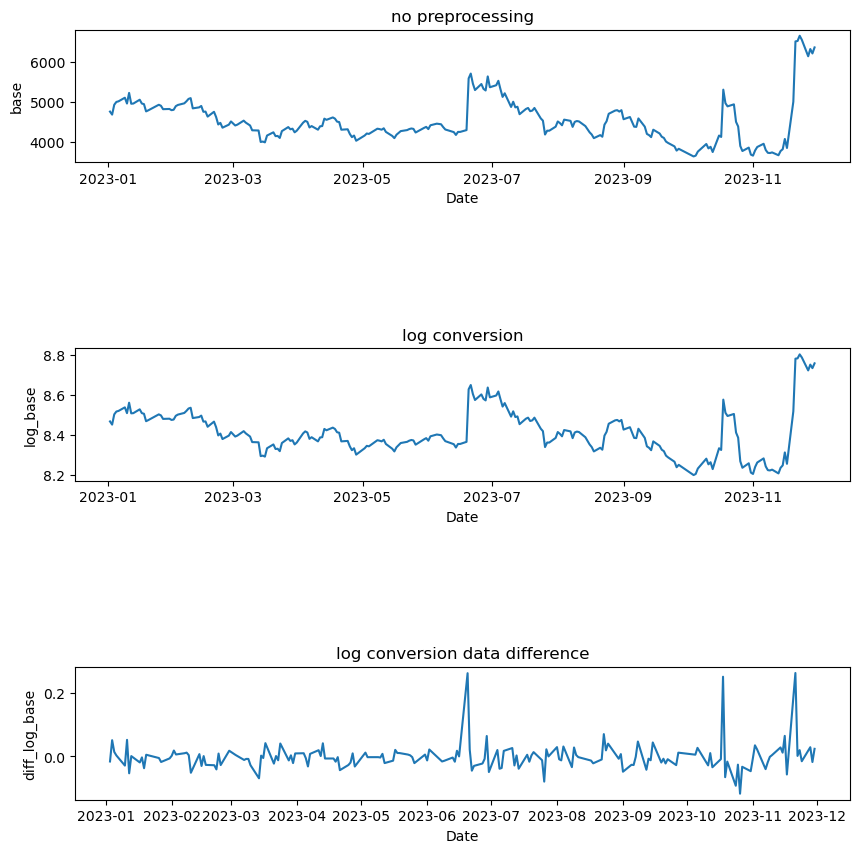

In [14]:
show_target_moving(dtnc)

In [15]:
##데이터 정규화 후 그래프로 상관관계 보기

def show_corr_graph(df, score_df, company):
    data = df.resample('D')['Close'].mean()
    
    #주가 데이터 log변환 및 차분
    scaled_target = np.log(data).diff()
    
    score = score_df['score']
    
    ##상승/하락 표시
    pos_target = scaled_target.copy()
    pos_target[pos_target < 0] = np.nan #상승한 날은 0 밑의 데이터는 표시X
    #상승 데이터 정규화
    pos_target = (pos_target - pos_target.min())/(pos_target.max()-pos_target.min())
    
    neg_target = scaled_target.copy()
    neg_target[neg_target >= 0] = np.nan #반대로 하락한 날은 0 이상 데이터는 표시X
    #하락 데이터 정규화
    neg_target = -1 * (neg_target.abs() - neg_target.abs().min())/(neg_target.abs().max()-neg_target.abs().min())
    
    ##긍정/부정 표시
    pos_score = score.copy()
    pos_score[pos_score < 0] = np.nan
    #긍정 점수 데이터 정규화
    pos_score = (pos_score - pos_score.min())/(pos_score.max()-pos_score.min())
    
    neg_score = score.copy()
    neg_score[neg_score >= 0] = np.nan
    #부정 점수 데이터 정규화
    neg_score = -1 * (neg_score.abs() - neg_score.abs().min())/(neg_score.abs().max()-neg_score.abs().min())
    
    #막대그래프로 주가 데이터 나타내기
    plt.figure(figsize=(20,10))
    plt.bar(x = pos_target.index, height = pos_target, color = 'r', width = 6, alpha = 0.5, label = 'pos_data')
    plt.bar(x = neg_target.index, height = neg_target, color = 'b', width = 6, alpha = 0.5, label = 'neg_data')
    
    #산점도로 긍정/부정 점수 나타내기
    plt.scatter(x = pos_score.index, y = pos_score, color = 'r', alpha = 0.3, s = 20, label = 'pos_score')
    plt.scatter(x = neg_score.index, y = neg_score, color = 'b', alpha = 0.3, s = 20, label = 'neg_score')
    
    plt.legend()
    
    
    plt.title('graph of {}'.format(company))
    
    
    

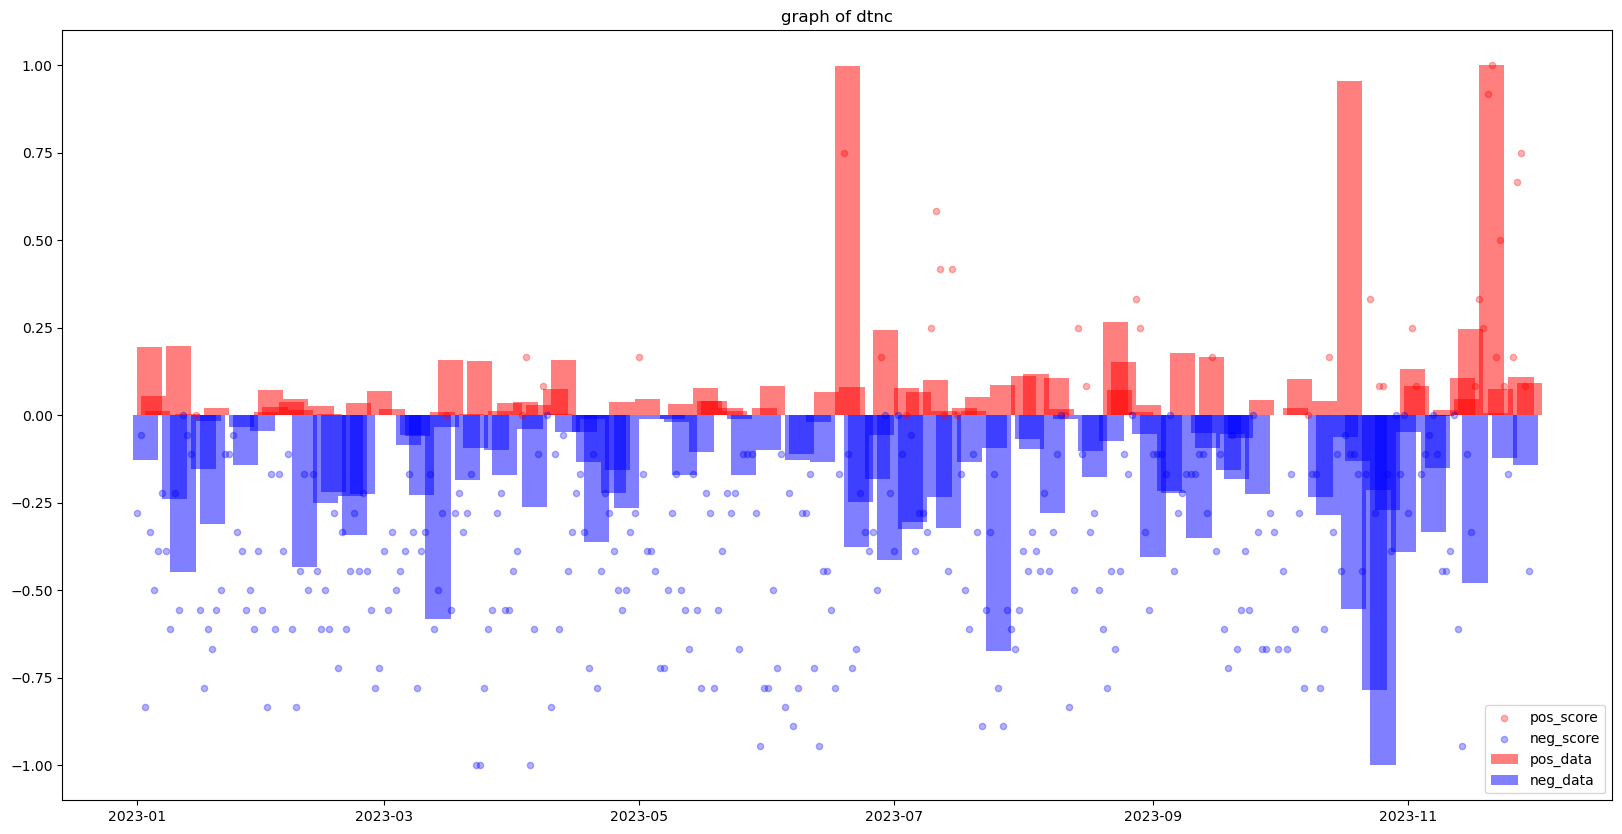

In [16]:
show_corr_graph(dtnc,result,'dtnc')

In [17]:
##피어슨 상관계수 구하기

def show_corr(df,score_df,company):
    data = df.resample('D')['Close'].mean()
    
    #주가 데이터 log변환 및 차분
    scaled_target = np.log(data).diff()
    
    score = score_df['score']
    
    ##상승 데이터 추출
    pos_target = scaled_target.copy()
    pos_target = pos_target[pos_target > 0]
    #상승 데이터 정규화
    pos_target = (pos_target - pos_target.min())/(pos_target.max()-pos_target.min())
    
    #하락 데이터 추출
    neg_target = scaled_target.copy()
    neg_target = neg_target[neg_target <= 0]
    #하락 데이터 정규화
    neg_target = -1 * (neg_target.abs() - neg_target.abs().min())/(neg_target.abs().max()-neg_target.abs().min())
    
    #다시 합치기
    resampled_target = pd.concat([pos_target, neg_target]).sort_index()
    
    ##긍정 데이터 추출
    pos_score = score.copy()
    pos_score = pos_score[pos_score > 0]
    #긍정 점수 데이터 정규화
    pos_score = (pos_score - pos_score.min())/(pos_score.max()-pos_score.min())
    
    #하락 데이터 추출
    neg_score = score.copy()
    neg_score = neg_score[neg_score <= 0]
    #부정 점수 데이터 정규화
    neg_score = -1 * (neg_score.abs() - neg_score.abs().min())/(neg_score.abs().max()-neg_score.abs().min())
    
    #다시 합치기
    resampled_score = pd.concat([pos_score, neg_score]).sort_index()
    
    #상관계수 분석을 위한 데이터프레임 생성
    merged_df = pd.merge(pd.DataFrame(resampled_target),pd.DataFrame(resampled_score), left_index = True, right_index = True)
    
    #상관계수 히트맵 그리기
    plt.title('heatmap of {}'.format(company))
    sns.heatmap(merged_df.corr(), linecolor = 'w', linewidth = 1, annot = True, cmap = 'summer')

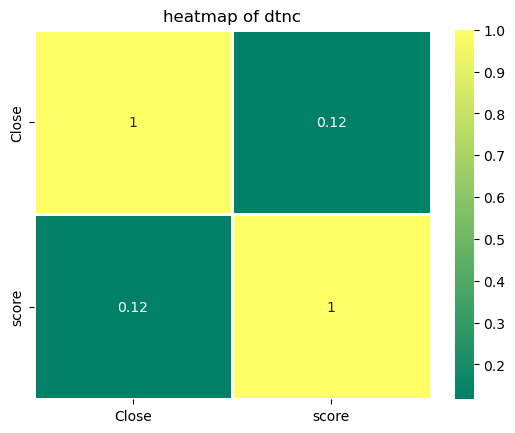

In [18]:
df2 = show_corr(dtnc, result,'dtnc')